# The multi-derivative DRAG pulse

In [1]:
import logging
from copy import deepcopy
import numpy as np
from numpy import pi
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrieve_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    iterative_cr_pulse_calibration,
    create_echoed_cnot_schedule,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

Setup a logging system.

In [2]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-07-01 15:22:58,665, MainThread 
INFO Logger initialized successfully.


Setup a simulator backend based on qiksit-dynamics and calibrate the single-qubit gates using the default calibrations from qiskit-experiment.

In [3]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1, J=0.003e9)

## Recursive DRAG pulse

### Hann pulse ramping time t_r=10ns

First, we reduce the ramping time to 10 ns (instead of 28.4 ns) and use a Hann pulse, which is similar to Gaussian shape. A short ramping time like this will introduce transition error on the first qubit.

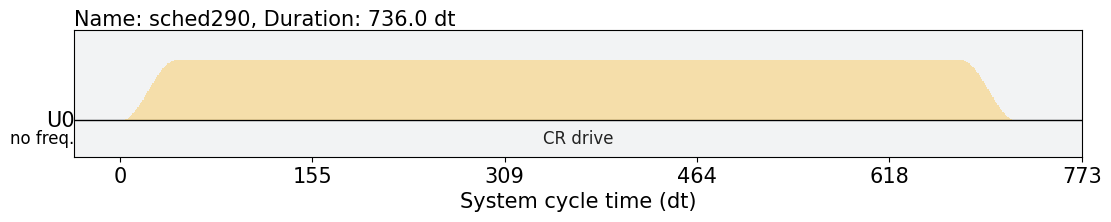

In [4]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-Hann-tr10"
params = {
    "order": "1",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : False,  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-07-01 15:24:46,848, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-07-01 15:24:46,848, MainThread 
INFO 

CR calibration round 1: 
2024-07-01 15:24:52,201, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:25:16,635, MainThread 
INFO CR tomography: 17643a41-5cf0-4093-ba35-a99a7bcad0c9
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e-10


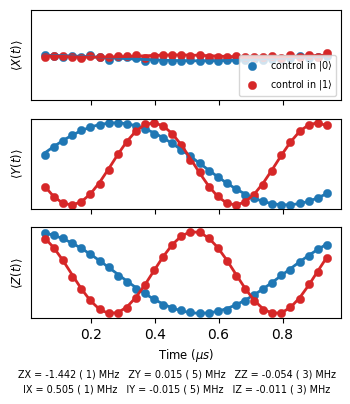

2024-07-01 15:25:19,644, MainThread 
INFO Tomography results:
{'IX': 0.5053513544378767, 'IY': -0.01511394856197339, 'IZ': -0.010735331866730587, 'ZX': -1.441885827598127, 'ZY': 0.014665037715651828, 'ZZ': -0.053929752231512605}

2024-07-01 15:25:19,646, MainThread 
INFO Remaining dominant error: IX: 0.5053513544378767 MHz

2024-07-01 15:25:19,649, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-07-01 15:25:19,650, MainThread 
INFO Probe amp shift [MHz]: -0.5053513544378767 MHz
2024-07-01 15:25:19,650, MainThread 
INFO Probe amp shift (amp): -0.0031752162051673703
2024-07-01 15:25:20,360, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:25:44,801, MainThread 
INFO CR tomography: 37ccc6f1-4c83-43a5-84bd-213a049e2b5a
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'ord

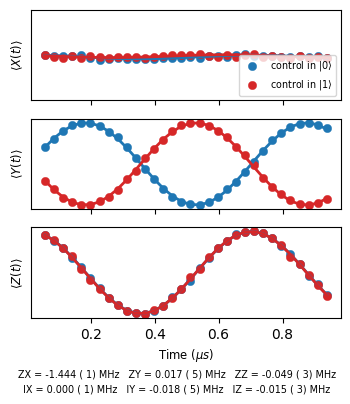

2024-07-01 15:25:47,431, MainThread 
INFO {'IX': 0.00013546815107609453, 'IY': -0.018149624780749257, 'IZ': -0.014580802102391937, 'ZX': -1.4441440583314222, 'ZY': 0.01699865306416697, 'ZZ': -0.04920552672254454}
2024-07-01 15:25:47,432, MainThread 
INFO Estimated drive scale: 
(0.15911227886296642+0.000956053390580328j)
(0.1591151511423473+0j)
0.006008599033561847
2024-07-01 15:25:47,437, MainThread 
INFO CR calibration data saved.
2024-07-01 15:25:47,438, MainThread 
INFO 

CR calibration round 2: 
2024-07-01 15:25:47,701, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:26:12,129, MainThread 
INFO CR tomography: 08e861c6-0ba2-47bb-88f4-3ad7c375c62a
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741

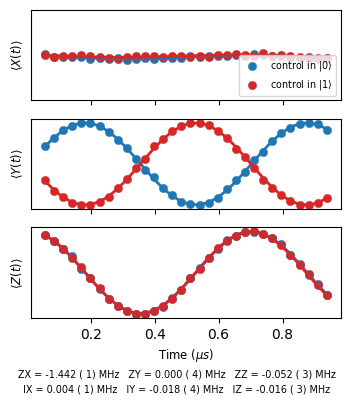

2024-07-01 15:26:14,747, MainThread 
INFO Tomography results:
{'IX': 0.003535123142779901, 'IY': -0.018380597679812215, 'IZ': -0.015710196031626194, 'ZX': -1.4418865143561899, 'ZY': 0.0004721008334462768, 'ZZ': -0.051847744529782976}

2024-07-01 15:26:14,749, MainThread 
INFO Frequency offset is updated to -15710.196031626194 Hz
2024-07-01 15:26:14,750, MainThread 
INFO Remaining dominant error: IY: 0.018380597679812215 MHz

2024-07-01 15:26:14,751, MainThread 
INFO Omega[GHz]/amp: 0.1591151511423473
2024-07-01 15:26:14,752, MainThread 
INFO Probe amp shift [MHz]: 0.1 MHz
2024-07-01 15:26:14,752, MainThread 
INFO Probe amp shift (amp): -0.000628475662324188
2024-07-01 15:26:15,023, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:26:39,248, MainThread 
INFO CR tomography: 4d25762a-fe1d-41e1-807b-233f32cc5757
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 

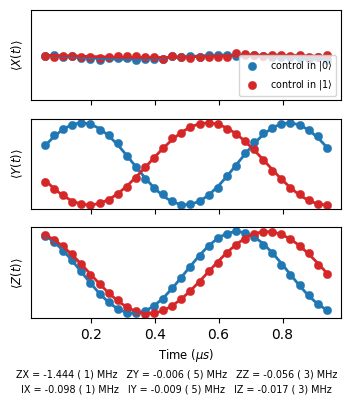

2024-07-01 15:26:41,772, MainThread 
INFO {'IX': -0.09817814779267257, 'IY': -0.009079078955522317, 'IZ': -0.01742524717890756, 'ZX': -1.443982336578226, 'ZY': -0.005591905753260133, 'ZZ': -0.0561184953062102}
2024-07-01 15:26:41,773, MainThread 
INFO Estimated drive scale: 
(0.1618412247807704-0.014800125576687608j)
(0.1625165399447871+0j)
-0.09119477734118737
2024-07-01 15:26:41,776, MainThread 
INFO CR calibration data saved.
2024-07-01 15:26:41,777, MainThread 
INFO 

CR calibration round 3: 
2024-07-01 15:26:42,181, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:27:04,511, MainThread 
INFO CR tomography: 76c9d729-1c72-41b5-b75b-647b8e124f14
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.251327412287

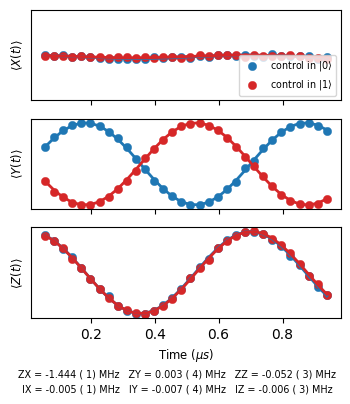

2024-07-01 15:27:06,925, MainThread 
INFO Tomography results:
{'IX': -0.004924436284008842, 'IY': -0.007235337169292774, 'IZ': -0.006468955861825346, 'ZX': -1.4439702631674225, 'ZY': 0.002609929687060781, 'ZZ': -0.05180223322109048}

2024-07-01 15:27:06,926, MainThread 
INFO Remaining dominant error: IY: 0.007235337169292774 MHz

2024-07-01 15:27:06,928, MainThread 
INFO Successfully calibrated.
2024-07-01 15:27:06,932, MainThread 
INFO CR calibration data saved.


In [5]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

2024-07-01 15:27:41,369, MainThread 
INFO Quantum process tomography job: 441ee630-bc31-4289-b081-f1fec77d1380
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-07-01 15:27:44,193, MainThread 
INFO Job saved to data/441ee630-bc31-4289-b081-f1fec77d1380



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

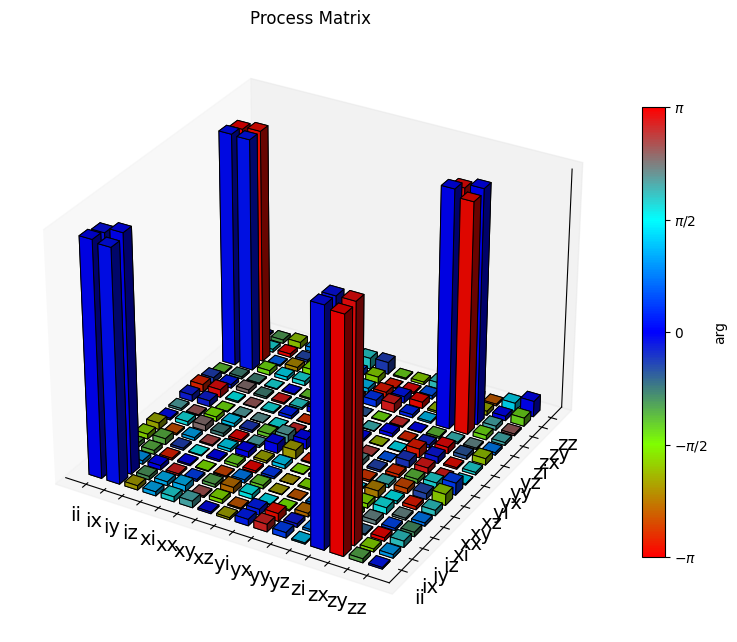

In [6]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

import qutip
qptdata = retrieve_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

Although we don't measure the leakage here, we can see from the plot above that there are more error than the tomography for longer-ramping pulse.

### Recursive DRAG pulse ramping time t_r=10ns

Using the same 10 ns pulse ramping time, we now use the recursive DRAG derived from Givens rotation.

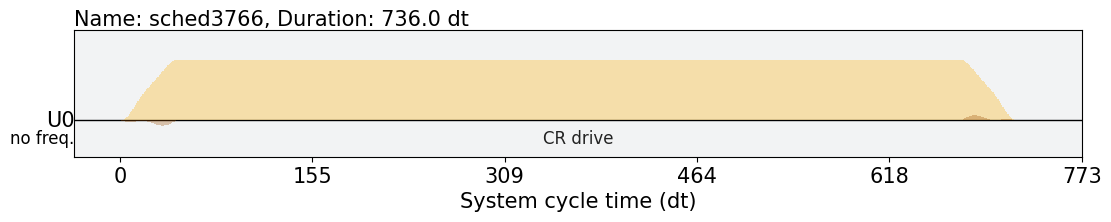

In [7]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-recursive-tr10"
params = {
    "order": "3",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : "exact",  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}
get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-07-01 15:28:03,006, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-07-01 15:28:03,007, MainThread 
INFO 

CR calibration round 1: 
2024-07-01 15:29:30,541, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:29:54,540, MainThread 
INFO CR tomography: 5a59d9ea-bfe8-4bc7-90d1-8b1167137cf6
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e

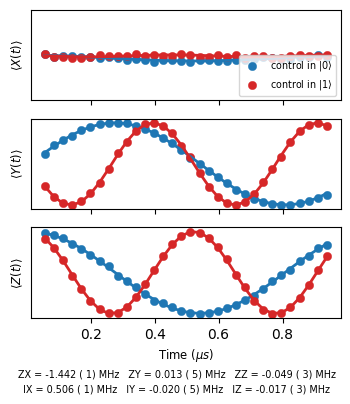

2024-07-01 15:29:57,590, MainThread 
INFO Tomography results:
{'IX': 0.5060744365918718, 'IY': -0.020293040644248212, 'IZ': -0.016887559291782046, 'ZX': -1.4422928908302706, 'ZY': 0.013300701274853732, 'ZZ': -0.048954596279847135}

2024-07-01 15:29:57,591, MainThread 
INFO Frequency offset is updated to -16887.559291782047 Hz
2024-07-01 15:29:57,592, MainThread 
INFO Remaining dominant error: IX: 0.5060744365918718 MHz

2024-07-01 15:29:57,593, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-07-01 15:29:57,594, MainThread 
INFO Probe amp shift [MHz]: -0.5060744365918718 MHz
2024-07-01 15:29:57,594, MainThread 
INFO Probe amp shift (amp): -0.0031797594643332362
2024-07-01 15:31:24,009, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:31:48,890, MainThread 
INFO CR tomography: 46b1f41a-e881-418a-af4f-9dd184857459
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 25

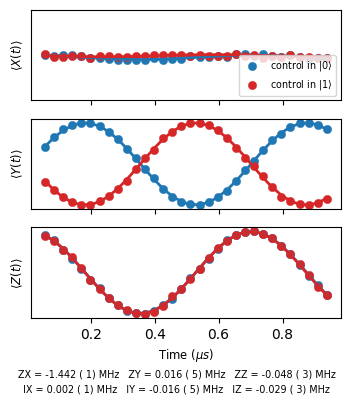

2024-07-01 15:31:51,925, MainThread 
INFO {'IX': 0.0022774712090023108, 'IY': -0.01600454775009012, 'IZ': -0.028598973564811347, 'ZX': -1.4421745620972377, 'ZY': 0.016253238677979037, 'ZZ': -0.04847479241355213}
2024-07-01 15:31:51,927, MainThread 
INFO Estimated drive scale: 
(0.15843870300060908-0.0013486846858264945j)
(0.15844444313038245-2.220365606867951e-19j)
-0.008512138047540602
2024-07-01 15:31:51,930, MainThread 
INFO CR calibration data saved.
2024-07-01 15:31:51,930, MainThread 
INFO 

CR calibration round 2: 
2024-07-01 15:33:16,035, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:33:40,694, MainThread 
INFO CR tomography: 3de5e49a-9d6d-4596-908d-2c52c907b470
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration'

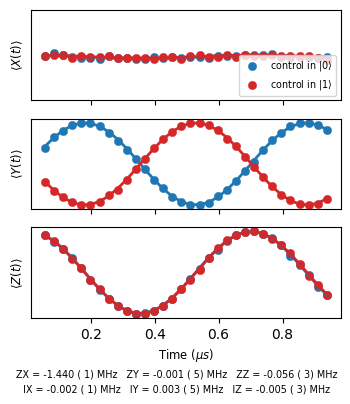

2024-07-01 15:33:44,017, MainThread 
INFO Tomography results:
{'IX': -0.002330136672935605, 'IY': 0.0025280024975669877, 'IZ': -0.0049673926531518635, 'ZX': -1.4395528182985697, 'ZY': -0.0007497853735160032, 'ZZ': -0.055591613643527965}

2024-07-01 15:33:44,018, MainThread 
INFO Remaining dominant error: IY: 0.0025280024975669877 MHz

2024-07-01 15:33:44,020, MainThread 
INFO Successfully calibrated.
2024-07-01 15:33:44,023, MainThread 
INFO CR calibration data saved.


In [8]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

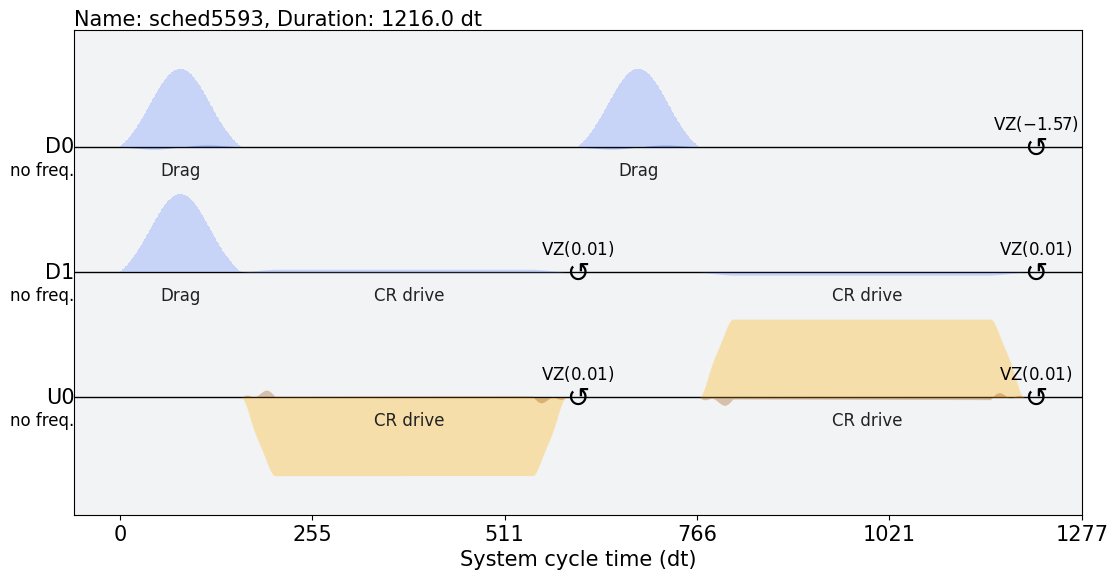

In [9]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

2024-07-01 15:34:43,228, MainThread 
INFO Quantum process tomography job: cccfe233-db67-45be-b1d5-c33933960a1b
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-07-01 15:34:46,427, MainThread 
INFO Job saved to data/cccfe233-db67-45be-b1d5-c33933960a1b



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

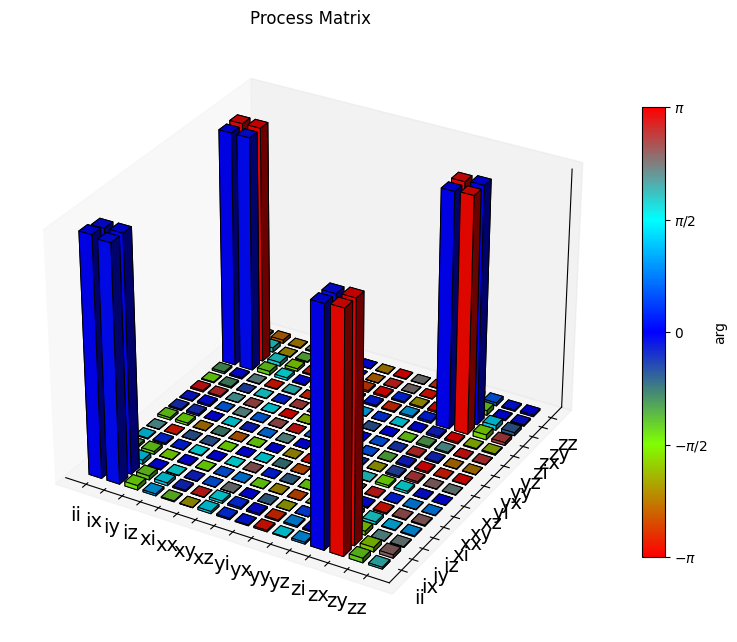

In [10]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

import qutip
qptdata = retrieve_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

## Calibration of the IY DRAG to suppress ZZ error
We Calibrate the IY-DRAG amplitude to suppress the ZZ error. We first perform three experiments with different beta parameters and then perform a linear fit.
- If the default Gaussian pulse is used, refer to the qiskit DRAG pulse for the definition of beta.
- If the custom DRAG pulse is used, `beta` refers to the constant scaling coefficient for the DRAG correction term.

2024-07-01 15:34:54,421, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-recursive-tr10.
2024-07-01 15:36:07,612, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:36:31,824, MainThread 
INFO CR tomography: ca565032-32f8-46d2-be14-602628ebaab5
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.009221652780580436, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003194992690110728, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 0.0}
x_gate_ix_params: None
frequency_offset: -16887.55929178

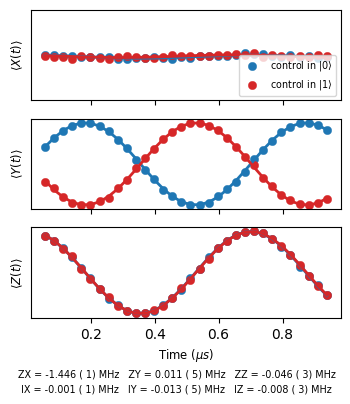

2024-07-01 15:37:49,470, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:38:14,139, MainThread 
INFO CR tomography: a893780e-5244-4475-9125-a553d31cabdc
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.009221652780580436, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003194992690110728, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': -10.0}
x_gate_ix_params: None
frequency_offset: -16887.559291782047
dt: 2.2222222222222221e-10

2024-07-01 15:38:16,979, MainThread 
INFO Job saved to data/a893780e

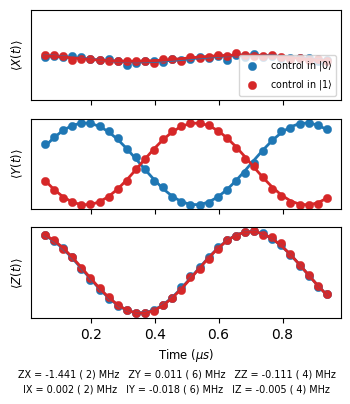

2024-07-01 15:39:36,480, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:40:00,868, MainThread 
INFO CR tomography: 7ef1e247-2113-422e-86eb-afe3e98c7438
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.009221652780580436, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003194992690110728, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 10.0}
x_gate_ix_params: None
frequency_offset: -16887.559291782047
dt: 2.2222222222222221e-10

2024-07-01 15:40:03,867, MainThread 
INFO Job saved to data/7ef1e247-

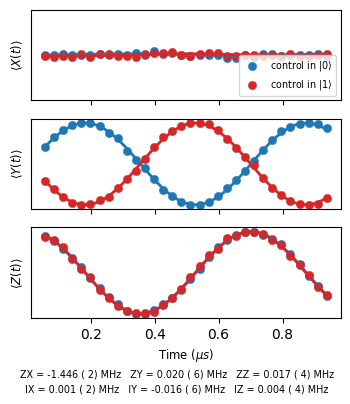

2024-07-01 15:40:04,134, MainThread 
INFO ZZ sampling measurements complete : [-0.045647064701017565, -0.11147973633486483, 0.01658952266350951].

2024-07-01 15:40:04,136, MainThread 
INFO Calibrated IY beta: 7.315691497528266



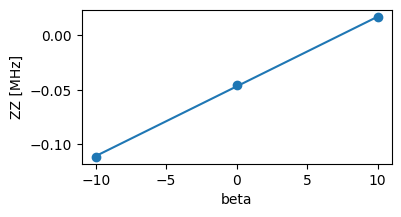

2024-07-01 15:41:24,601, MainThread 
INFO Tomography circuits have been generated.
2024-07-01 15:41:49,460, MainThread 
INFO CR tomography: 5a7b7263-106e-4dc0-abde-e29740eaa504
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.009221652780580436, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.003194992690110728, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 7.315691497528266}
x_gate_ix_params: None
frequency_offset: -16887.559291782047
dt: 2.2222222222222221e-10

2024-07-01 15:41:52,363, MainThread 
INFO Job saved to d

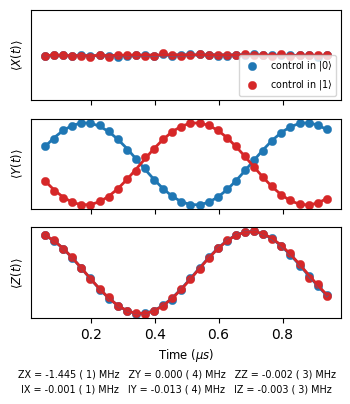

2024-07-01 15:41:52,616, MainThread 
INFO Updated coupling strength: {'IX': -0.0013719020894037918, 'IY': -0.013413573750723195, 'IZ': -0.0025098267799492915, 'ZX': -1.4448340462922418, 'ZY': 0.00022104094611558796, 'ZZ': -0.002485483579343281}
2024-07-01 15:41:52,619, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [11]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True, delta_beta=10.)

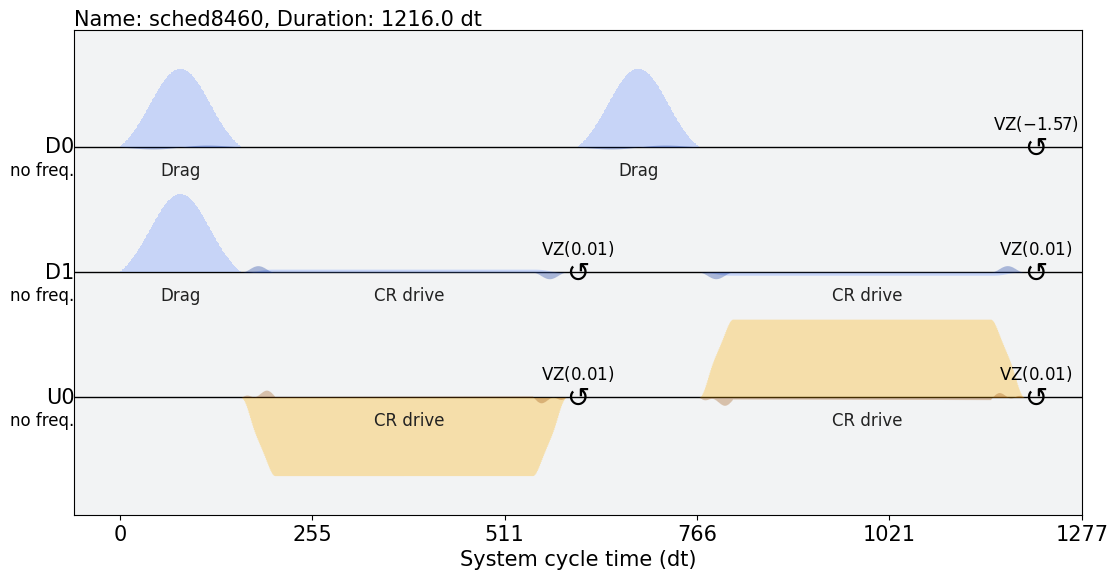

In [12]:
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()